<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> Tarea 3 - Ensamblados y modelos avanzados</h1>

<H3 align='center'> <i>Felipe Olavarria, Rol:201673606-9</i> </H3>
<H3 align='center'> <i>Jean Aravena, Rol:201673573-9</i> </H3>
<hr style="height:2px;border:none"/>

In [58]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize

## 2. Detección de acoso en *Twitter*
---
En las redes sociales muchas veces se encuentra con un cierto comportamiento indeseable para los usuarios, tal como racismo, misógeno, grupos de odio o *trolls*. El poder detectar de manera automática ciertos patrones en el comportamiento para tomar una acción debe ser crucial para reducir el tiempo y esfuerzo humano. En esta actividad se trabajará sobre *tweets* la red social de *twitter* para detectar comportamiento *online* de acoso (*harassment*), que por lo general, incluye *flaming* como lenguaje abusivo o insultos, *doxing* como mostrar la información personal de una mujer, por ejemplo el domicilio o número de teléfono, la suplantación o la vergüenza pública por destruir la reputación de las personas.

<img src="https://kidshelpline.com.au/sites/default/files/bdl_image/header-T-OH.png" title="Title text" width="45%"  />

En algunos problemas como este, el comportamiento a detectar puede ser asociado a una anomalía (*outlier*) del comportamiento normal de los usuarios en las redes sociales. Esto es una de las causas de la dificultad del problema, puesto que es **altamente desbalanceado**, donde aproximadamente un 10% de los *tweets* corresponden a acoso (*harassment*).

Los datos trabajados corresponderan a *tweets* etiquetados como *harassment* (con valor 1) o no (con valor 0) -- la tarea a detectar--. Además si desea utilizar, se incluye la información del tipo de *harassment* en el conjunto de entrenamiento como atributos extras. El conjunto de pruebas solo contiene los *tweets* a ser etiquetados.

In [53]:
#Train df
df_train = pd.read_csv("Train_data.csv")

df_train_text = df_train.tweet_content
labels_train = df_train.harassment.values

#Test df
df_test = pd.read_csv("Test_input.csv")

df_test_text = df_train.tweet_content
labels_test = df_train.harassment.values

df_train.columns

Index(['id', 'tweet_content', 'harassment', 'IndirectH', 'PhysicalH',
       'SexualH'],
      dtype='object')

In [54]:
df_train.shape

(5703, 6)

***Tenemos 5703 datos diferentes en el dataset, cada uno con 6 atributos.***

In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5703 entries, 0 to 5702
Data columns (total 6 columns):
id               5703 non-null int64
tweet_content    5703 non-null object
harassment       5703 non-null int64
IndirectH        5703 non-null int64
PhysicalH        5703 non-null int64
SexualH          5703 non-null int64
dtypes: int64(5), object(1)
memory usage: 267.4+ KB


***Se muestra el resumen del dataframe, en el cual no existen registros nulos para ninguna de las 6 columnas.
Además se informa el tipo de dato que presenta cada una de los atributos y la memoria utilizada.***

In [56]:
df_train.describe()

,id,harassment,IndirectH,PhysicalH,SexualH
count,5703.000000,5703.000000,5703.000000,5703.000000,5703.000000
mean,6562.964229,0.096265,0.022094,0.019639,0.054533
std,2529.460613,0.294980,0.147001,0.138768,0.227086
min,2123.000000,0.000000,0.000000,0.000000,0.000000
25%,4367.500000,0.000000,0.000000,0.000000,0.000000
50%,6583.000000,0.000000,0.000000,0.000000,0.000000
75%,8835.500000,0.000000,0.000000,0.000000,0.000000
max,10620.000000,1.000000,1.000000,1.000000,1.000000


***El método df.describe() genera estadísticas descriptivas del dataframe en cuestión. Se informa el valor promedio, dispersión y la forma de la distribución de los datos según atributo.***

In [57]:
from sklearn.model_selection import train_test_split

c = df_train.shape[0] # 5703 datos
d = int(c * 0.3) # 1710 datos en df_val_text y 3993 datos en df_train_text

df_train_text, df_val_text, labels_train, labels_val  = train_test_split(df_train_text, labels_train, test_size = d, random_state=0)


***El tamaño de entrenamiento correspondera al 70% de los datos.***

> Se realiza un pre-procesamiento a los textos para normalizar un poco su estructura, donde se pasa el texto a minúsculas (lower-casing), se reducen las mútliples letras, se eliminan palabras sin significados como artículos, pronombres y preposiciones (stop word removal), además de pasar las palabras a su tronco léxico con la técnica de lemmatizer

In [59]:
def base_word(word):
    wordlemmatizer = WordNetLemmatizer()
    return wordlemmatizer.lemmatize(word) 
def word_extractor(text):
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text) #substitute multiple letter by two
    words = ""
    wordtokens = [ base_word(word.lower()) for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in commonwords: #delete stopwords
            words+=" "+word
    return words

texts_train = [word_extractor(text) for text in df_train_text]
texts_val = [word_extractor(text) for text in df_val_text]
texts_test = [word_extractor(text) for text in df_test_text]

> Se construye una representación vectorial a los textos de entrada para poder ser manejados y clasificados por los modelos de aprendizaje. 

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 1), binary=False) #TF representation
vectorizer.fit(texts_train)

features_train = vectorizer.transform(texts_train)
features_val = vectorizer.transform(texts_val)
features_test = vectorizer.transform(texts_test)


vocab = vectorizer.get_feature_names()

> Se entrena un modelo de Regresión Logística Regularizado (utilizando como penalizador la norma $l_2$), encontrando el parámetro C óptimo para el algoritmo.

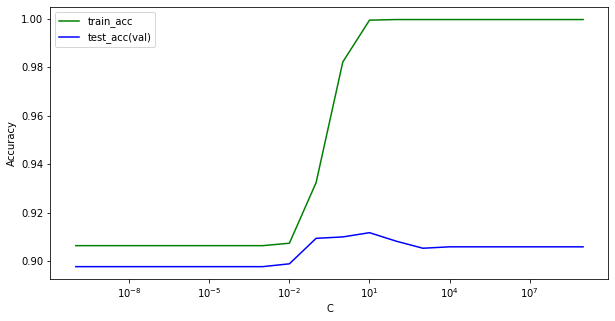

Máximo test_acc: 0.9117, C óptimo: 10.0
	 train_acc: 0.9995


In [63]:
from sklearn.linear_model import LogisticRegression
def do_LOGIT(x,y,xv,yv, param):
    #print("Param C= ",param)
    model= LogisticRegression(solver = 'liblinear')
    model.set_params(C=param)
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc
Cs = [10**i for i in np.arange(-10,10,1).astype(float)]

ltrain = list()
ltest  = list()
for i in Cs:
    model, train_acc, test_acc = do_LOGIT(features_train,labels_train,features_val,labels_val, param = i)
    ltrain.append(train_acc)
    ltest.append(test_acc)

plt.figure(figsize=(10,5))
plt.semilogx(Cs, ltrain, c = 'green', label = 'train_acc')
plt.semilogx(Cs, ltest, c = 'blue', label = 'test_acc(val)')
plt.ylabel("Accuracy")
plt.xlabel("C")
plt.legend()
plt.show()

#####
print("Máximo test_acc: "+str(round(max(ltest),4)) + ", C óptimo: "+ str(round(Cs[ltest.index(max(ltest))],4)))
print("\t train_acc: "+str(round(ltrain[ltest.index(max(ltest))],4)))

In [76]:
#Regresión Logística Regularizado C = 10
model, train_acc, test_acc = do_LOGIT(features_train,labels_train,features_test,labels_test, param = 10)

y_pred = model.predict(features_val)

In [73]:
from  sklearn.metrics import f1_score
f1_score(labels_val, y_pred, average='binary')

0.43445692883895126

C:\Users\FAMILIA\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


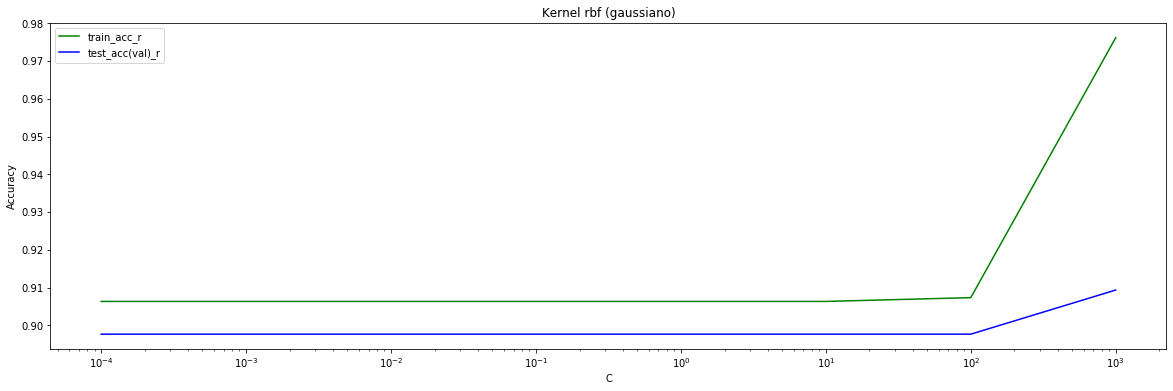


Máximo test_acc kernel=rbf (gaussiano): 0.9094, C óptimo: 1000.0
	 train_acc kernel=rbf (gaussiano): 0.9762


In [77]:
from sklearn.svm import SVC as SVM #SVC is for classification
def do_SVM(x,y,xv,yv, param, kernel,param2=3):
    #print("Param C= ",C, 'Kernel= ', kernel)
    model= SVM()
    model.set_params(C=param,kernel=kernel,degree=param2) #try rbf and linear at least
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc
Cs = [10**i for i in np.arange(-4,4).astype(float)]

ltrain_r = list()
ltest_r = list()
for i in Cs:
    model, train_acc, test_acc = do_SVM(features_train,labels_train,features_val,labels_val, param = i,kernel="rbf")
    ltrain_r.append(train_acc)
    ltest_r.append(test_acc)
    
plt.figure(figsize=(20,6))

plt.semilogx(Cs, ltrain_r, c = 'green', label = 'train_acc_r')
plt.semilogx(Cs, ltest_r, c = 'blue', label = 'test_acc(val)_r')
plt.ylabel("Accuracy")
plt.xlabel("C")
plt.title("Kernel rbf (gaussiano)")
plt.legend()
plt.show()

#####
print("\nMáximo test_acc kernel=rbf (gaussiano): "+str(round(max(ltest_r),4)) + ", C óptimo: "+ str(round(Cs[ltest_r.index(max(ltest_r))],4)))
print("\t train_acc kernel=rbf (gaussiano): "+str(round(ltrain_r[ltest_r.index(max(ltest_r))],4)))

In [97]:
#SVM kernel rbf (gaussiano) regularizado C = 1000
model, train_acc, test_acc = do_SVM(features_train,labels_train,features_val,labels_val, param = 1000,kernel="rbf")

y_pred = model.predict(features_val)
f1_score(labels_val, y_pred, average='binary')

C:\Users\FAMILIA\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.392156862745098

In [84]:
from sklearn.tree import DecisionTreeClassifier as Tree
def do_Tree(x,y,xv,yv, param_d=None, param_m=2):
    model= Tree()
    #print("Param Max-D= ",param_d, 'Min-samples-S= ', param_m)
    model.set_params(max_depth=param_d, min_samples_split=param_m) 
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc
Depths = np.arange(1,features_train.shape[0]/10, 10) #choose steps
SamplesS = np.arange(2, features_train.shape[0] , 10 ) #choose steps


ltrain = np.zeros(shape=(Depths.shape[0],SamplesS.shape[0])) 
ltest  = np.zeros(shape=(Depths.shape[0],SamplesS.shape[0])) 
for i in range(Depths.shape[0]):
    for j in range(SamplesS.shape[0]):
        model, train_acc, test_acc = do_Tree(features_train,labels_train,features_val,labels_val, param_d = Depths[i], param_m=SamplesS[j])
        ltrain[i][j] = train_acc
        ltest[i][j]  = test_acc

Máximo test_acc: 0.9164, Max depth óptimo: 21.0 Min samples óptimo: 12
	 train_acc: 0.9617


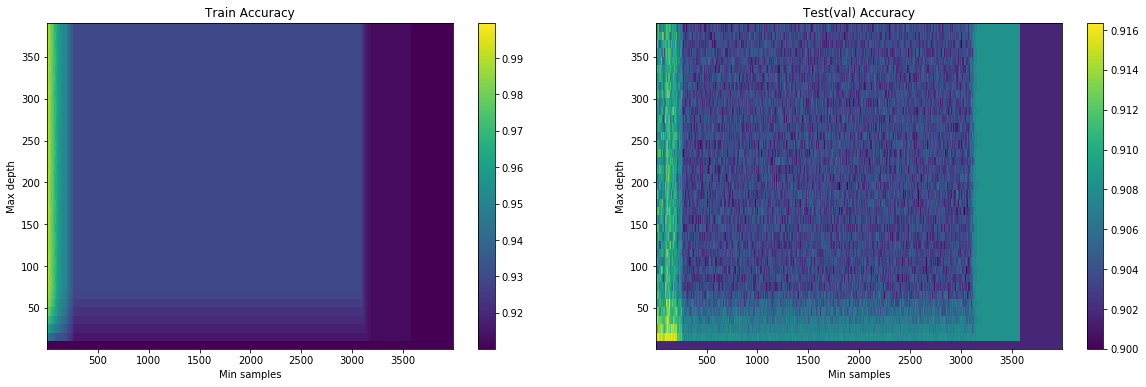

In [85]:
%matplotlib inline
#test = np.asarray(zs_train,).reshape(200,200)
#print(len(xs_train))

plt.figure(figsize=(20,6))

plt.subplot(121)
plt.pcolormesh(SamplesS,Depths,ltrain)#,vmin=0, vmax=1)
plt.title("Train Accuracy")
plt.xlabel("Min samples")
plt.ylabel("Max depth")
plt.colorbar()

plt.subplot(122)
plt.pcolormesh(SamplesS,Depths,ltest)#,vmin=0, vmax=1)
plt.title("Test(val) Accuracy")
plt.xlabel("Min samples")
plt.ylabel("Max depth")
plt.colorbar()

m = -1
k = -1
l = -1

for i in range(Depths.shape[0]):
    for j in range(SamplesS.shape[0]):
        if ltest[i][j] > m:
            m = ltest[i][j]
            k = i
            l = j

print("Máximo test_acc: "+str(round(m,4)) + ", Max depth óptimo: "+ str(round(Depths[k],4)) + " Min samples óptimo: "+ str(round(SamplesS[l],4)))
print("\t train_acc: "+str(round(ltrain[k][l],4)))

In [86]:
#arbol de decision regularizado max_depth = ,min_samples_split = 
model, train_acc, test_acc = do_Tree(features_train,labels_train,features_val,labels_val, param_d = 21, param_m=12)

In [87]:
y_pred = model.predict(features_val)
f1_score(labels_val, y_pred, average='binary')

0.4410646387832699

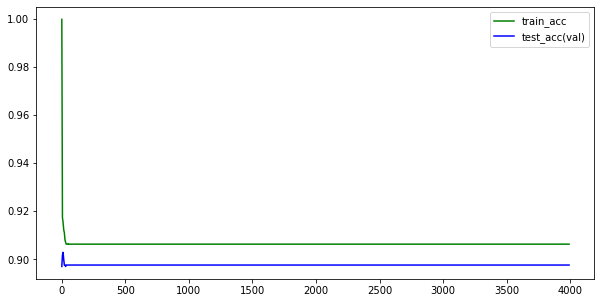

Máximo test_acc: 0.9, K óptimo: 11
	 train_acc: 0.92


In [96]:
from sklearn.neighbors import KNeighborsClassifier
def do_KNN(x,y,xv,yv, param):
    model = KNeighborsClassifier()
    #print("Param K= ",param)
    model.set_params(n_neighbors=param)
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc
Ks = np.arange(1, features_train.shape[0], 5)

ltrain = list()
ltest  = list()
for i in Ks:
    model, train_acc, test_acc = do_KNN(features_train,labels_train,features_val,labels_val, param = i)
    ltrain.append(train_acc)
    ltest.append(test_acc)
    
plt.figure(figsize=(10,5))
plt.plot(Ks, ltrain, c = 'green', label = 'train_acc')
plt.plot(Ks, ltest, c = 'blue', label = 'test_acc(val)')
plt.legend()
plt.show()

print("Máximo test_acc: "+str(round(max(ltest),2)) + ", K óptimo: "+ str(round(Ks[ltest.index(max(ltest))],2)))
print("\t train_acc: "+str(round(ltrain[ltest.index(max(ltest))],2)))

In [99]:
#KNN regularizado con K = 11
model, train_acc, test_acc = do_KNN(features_train,labels_train,features_val,labels_val, param = 11)

y_pred = model.predict(features_val)
f1_score(labels_val, y_pred, average='binary')

0.12631578947368421

> El archivo de submission debe contener las predicciones de harassment (0 o 1) a cada dato de pruebas, además de la columna de id asociado al dato, iniciando en 1. Si leyó de manera ordenada el archivo de pruebas, se puede generar de la siguiente manera:

In [ ]:
df_aux = pd.DataFrame()
df_aux["id"] = np.arange(1, 1+y_pred.shape[0])
df_aux["harassment"] = y_pred.astype('int')
df_aux.to_csv("test_estimation.csv", index=False)